In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import missingno as mno
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("london_weather.csv")
data.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [4]:
#Custom data info
custom_data = pd.DataFrame({
    "dtypes" : data.dtypes,
    "counts" : data.count(),
    "missing" : data.isnull().sum(),
    "variance" : data.var(axis=0)
} , index=data.columns)

custom_data

dtypes  counts  missing      variance
date                int64   15341        0  1.469370e+10
cloud_cover       float64   15322       19  4.285199e+00
sunshine          float64   15341        0  1.622752e+01
global_radiation  float64   15322       19  7.902903e+03
max_temp          float64   15335        6  4.296479e+01
mean_temp         float64   15305       36  3.282956e+01
min_temp          float64   15339        2  2.837433e+01
precipitation     float64   15335        6  1.397668e+01
pressure          float64   15337        4  1.101918e+06
snow_depth        float64   13900     1441  2.977152e-01

In [5]:
profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

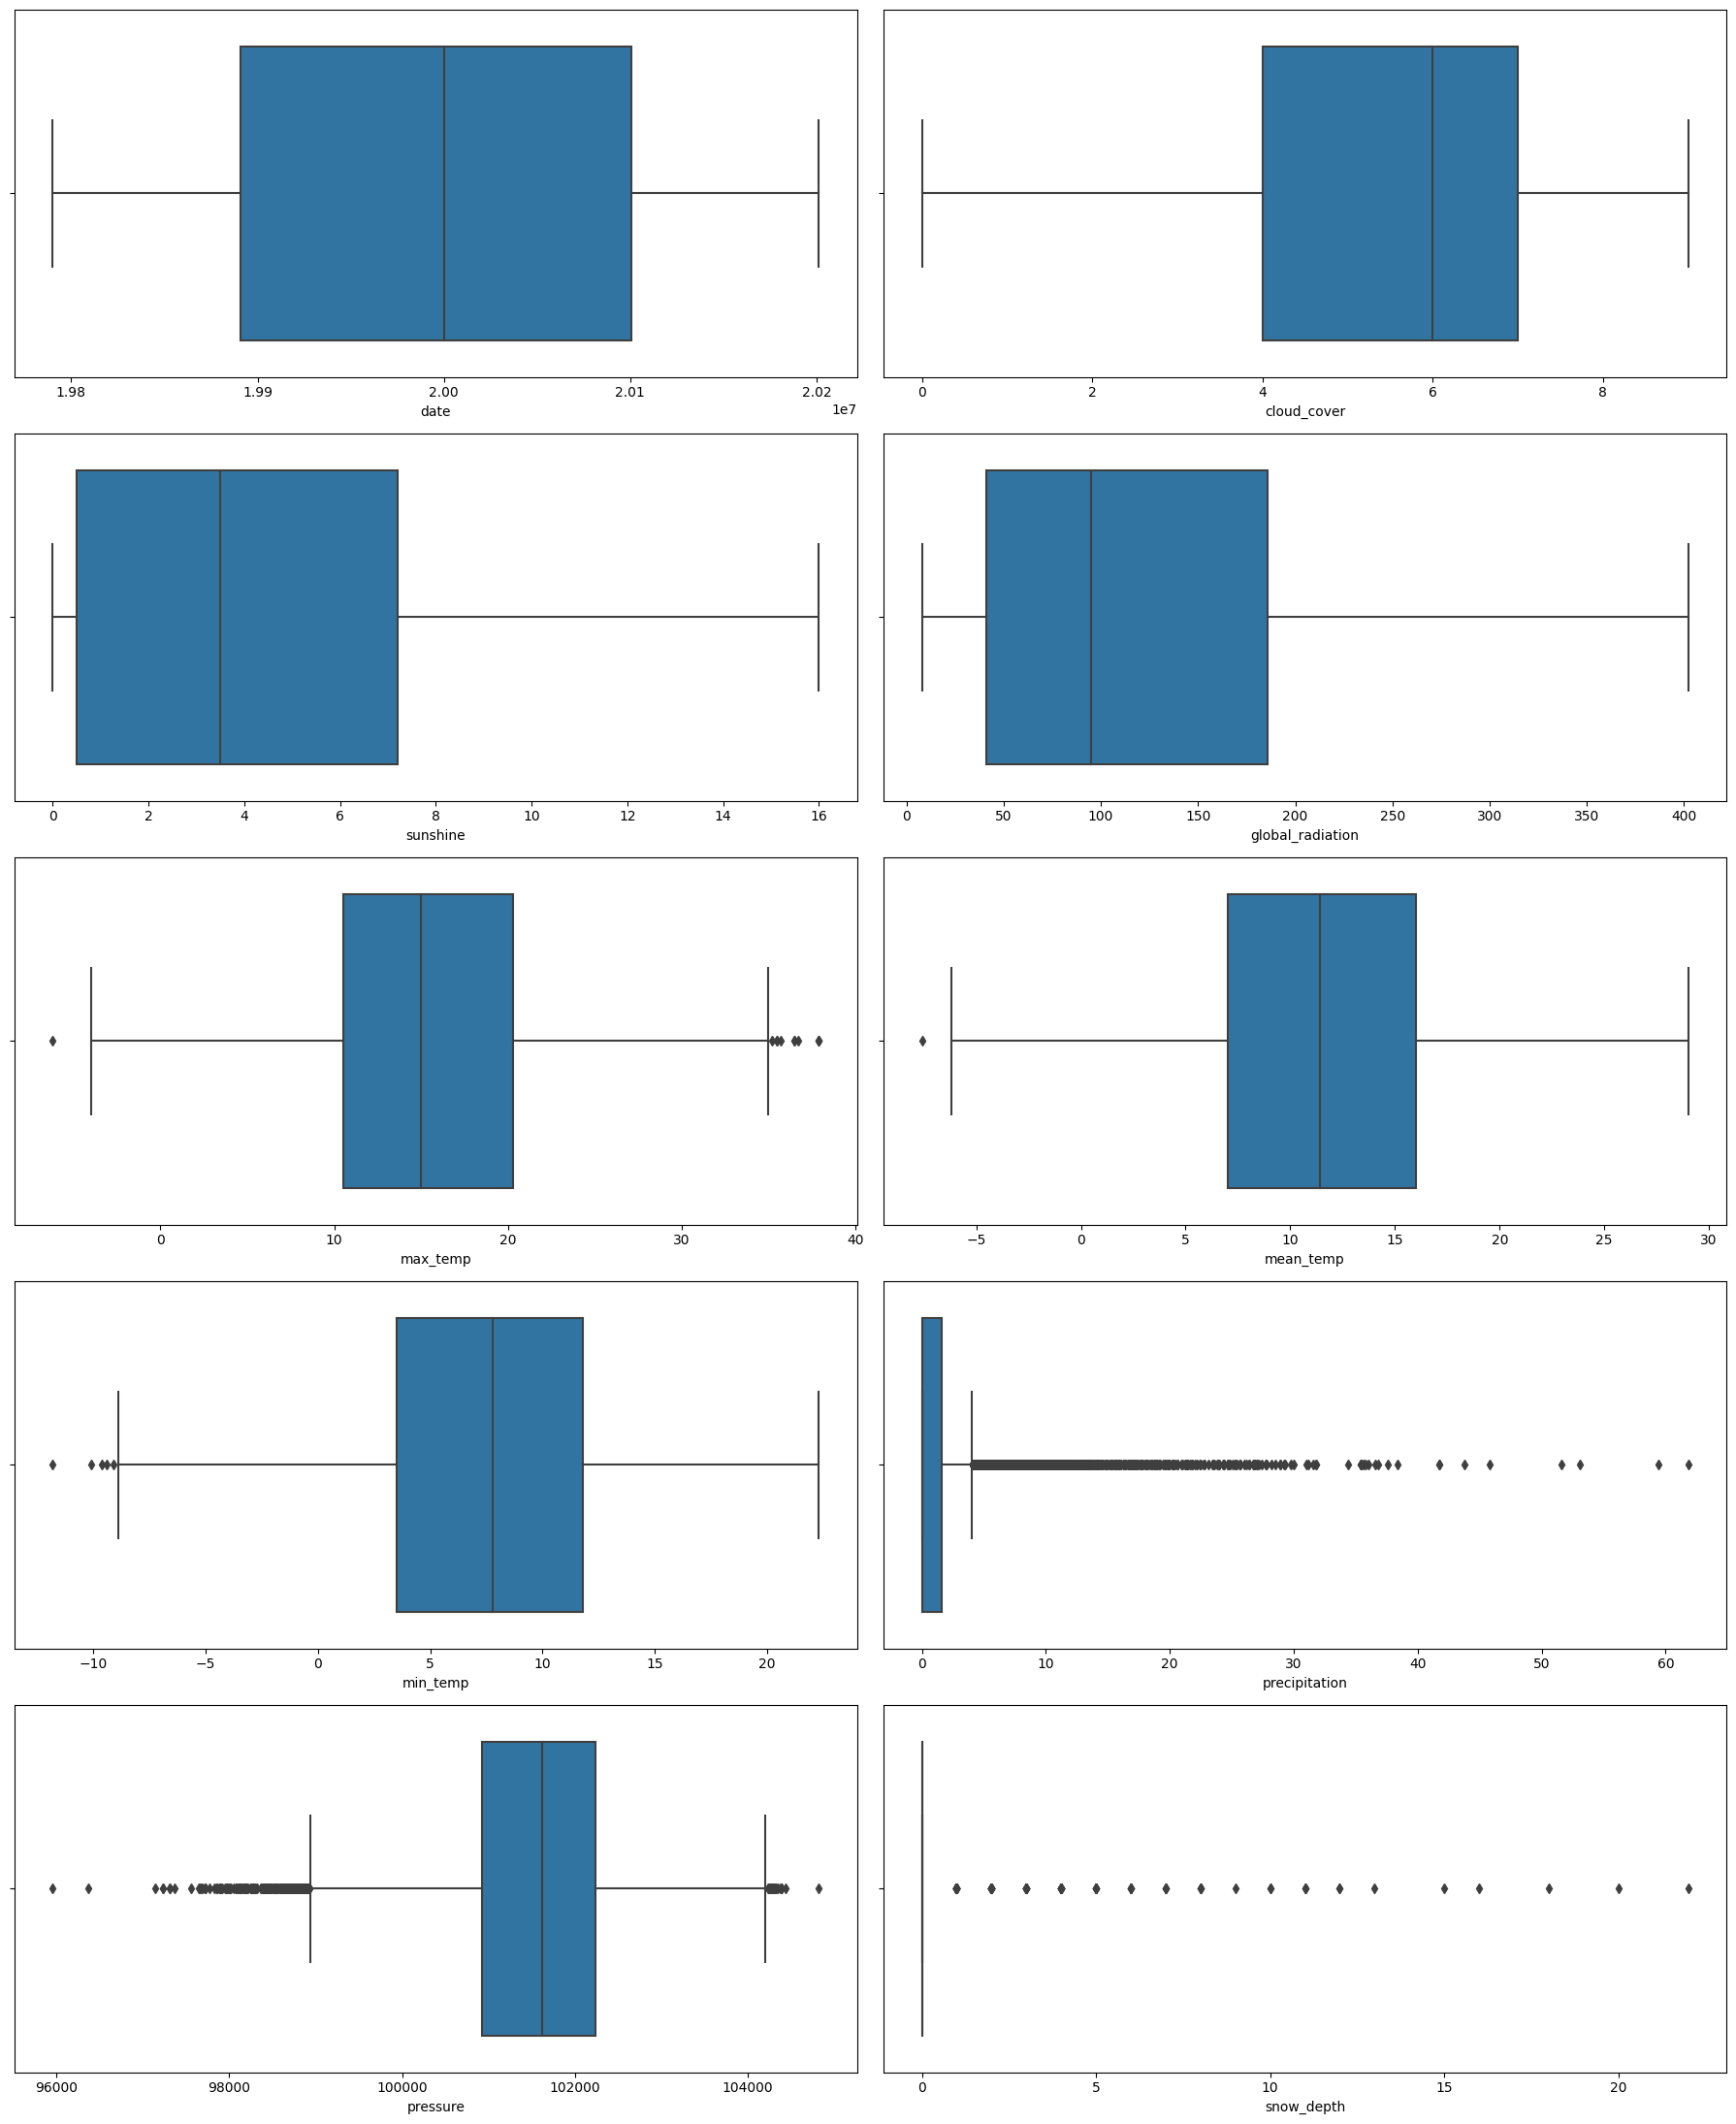

In [6]:
fig, ax = plt.subplots(5, 2, figsize=(18, 22))
 
ax = ax.flatten()

#features
columns = list(data.columns)

# Loop through the columns and create a boxplot for each
for idx, column in enumerate(columns):
    sns.boxplot(ax=ax[idx], x=data[column])


# Adjust layout to avoid overlap
plt.tight_layout()

Based on the box plot you shared, here’s a breakdown of how to handle outliers in our dataset for different features, particularly considering that "max_temp" is our target variable.

### 1. **Target Variable - max_temp:**
   - **Observation:** The "max_temp" feature has a few outliers on the lower and upper ends.
   - **Approach:**
     - **Assess Outliers' Validity:** Before removing or adjusting these outliers, we should assess whether they are valid data points. Sometimes extreme values may represent actual events (e.g., unusually hot or cold days).
     - **Trimming/Clipping:** If the outliers are not valid, we can remove them or cap them at a certain percentile (e.g., 1st and 99th percentiles).
### 2. **Features with Significant Outliers:**
   - **Precipitation:** This feature shows a large number of outliers on the higher end. Precipitation can have naturally high variability, but it might still benefit from treatment.
   - **Pressure:** Outliers are present on both ends, particularly on the lower end.
   - **Snow Depth:** This feature also has many outliers, mainly concentrated towards the higher values.

   **Approach:**
   - **Log Transformation:** For positively skewed data with many high-value outliers (e.g., precipitation and snow depth), applying a log transformation can normalize the distribution.
   - **Capping:** You can cap the extreme values at a reasonable threshold based on domain knowledge (e.g., capping the top 1% of snowfall).
   - **Robust Scaler:** Using a robust scaler can help mitigate the effect of outliers during scaling, as it uses the median and interquartile range instead of the mean and standard deviation.
   - **Winsorization:** This involves limiting extreme values to reduce the impact of possibly spurious outliers.

### 3. **Features with Few Outliers:**
   - **Sunshine, Mean Temp, Global Radiation:** These features seem to have few or no significant outliers. we may not need to adjust them.

   **Approach:**
   - **No Action Required:** Since these features are well-behaved, we might not need to handle outliers for them. However, you can still apply standard scaling to keep all features on a similar scale for certain models.


<Axes: >

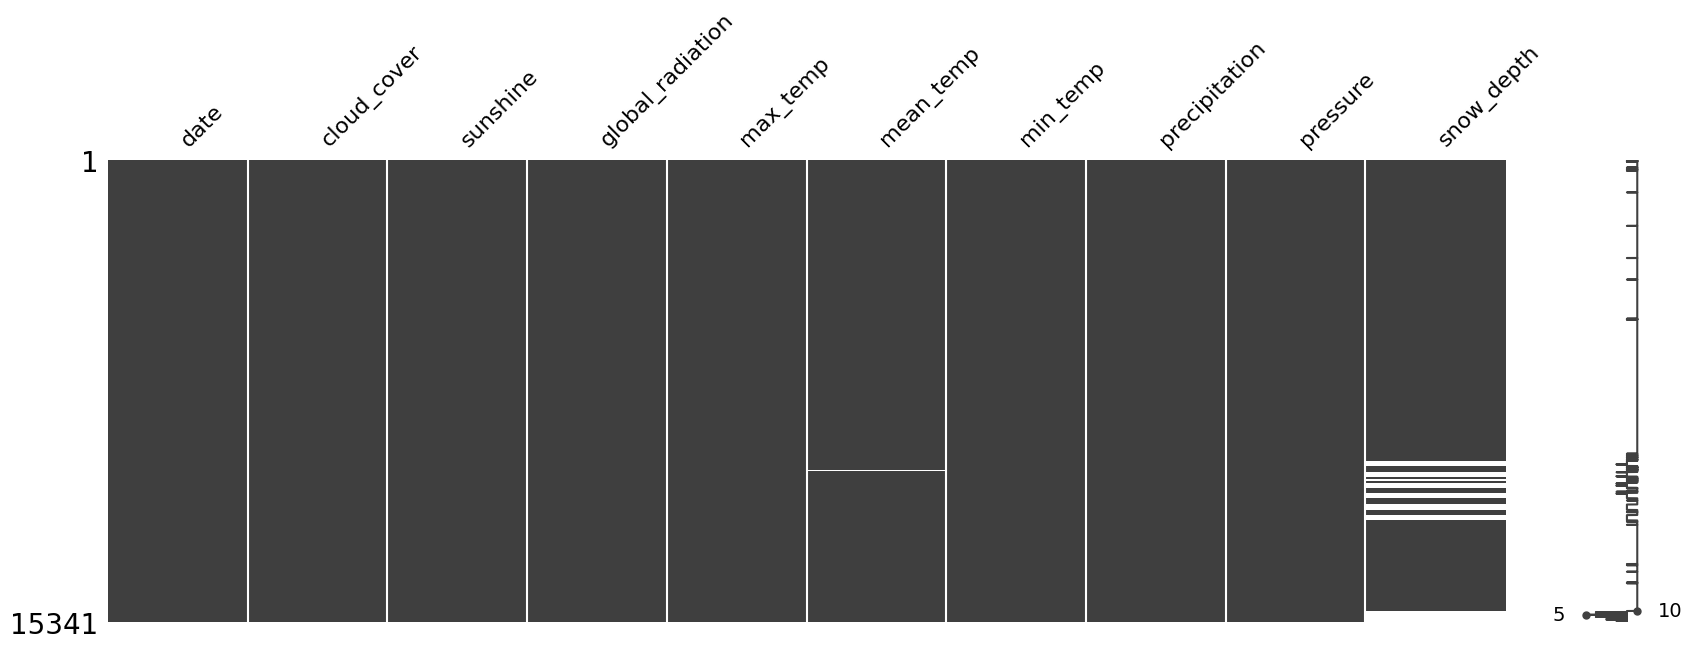

In [7]:
mno.matrix(data, figsize = (20, 6))

<Axes: >

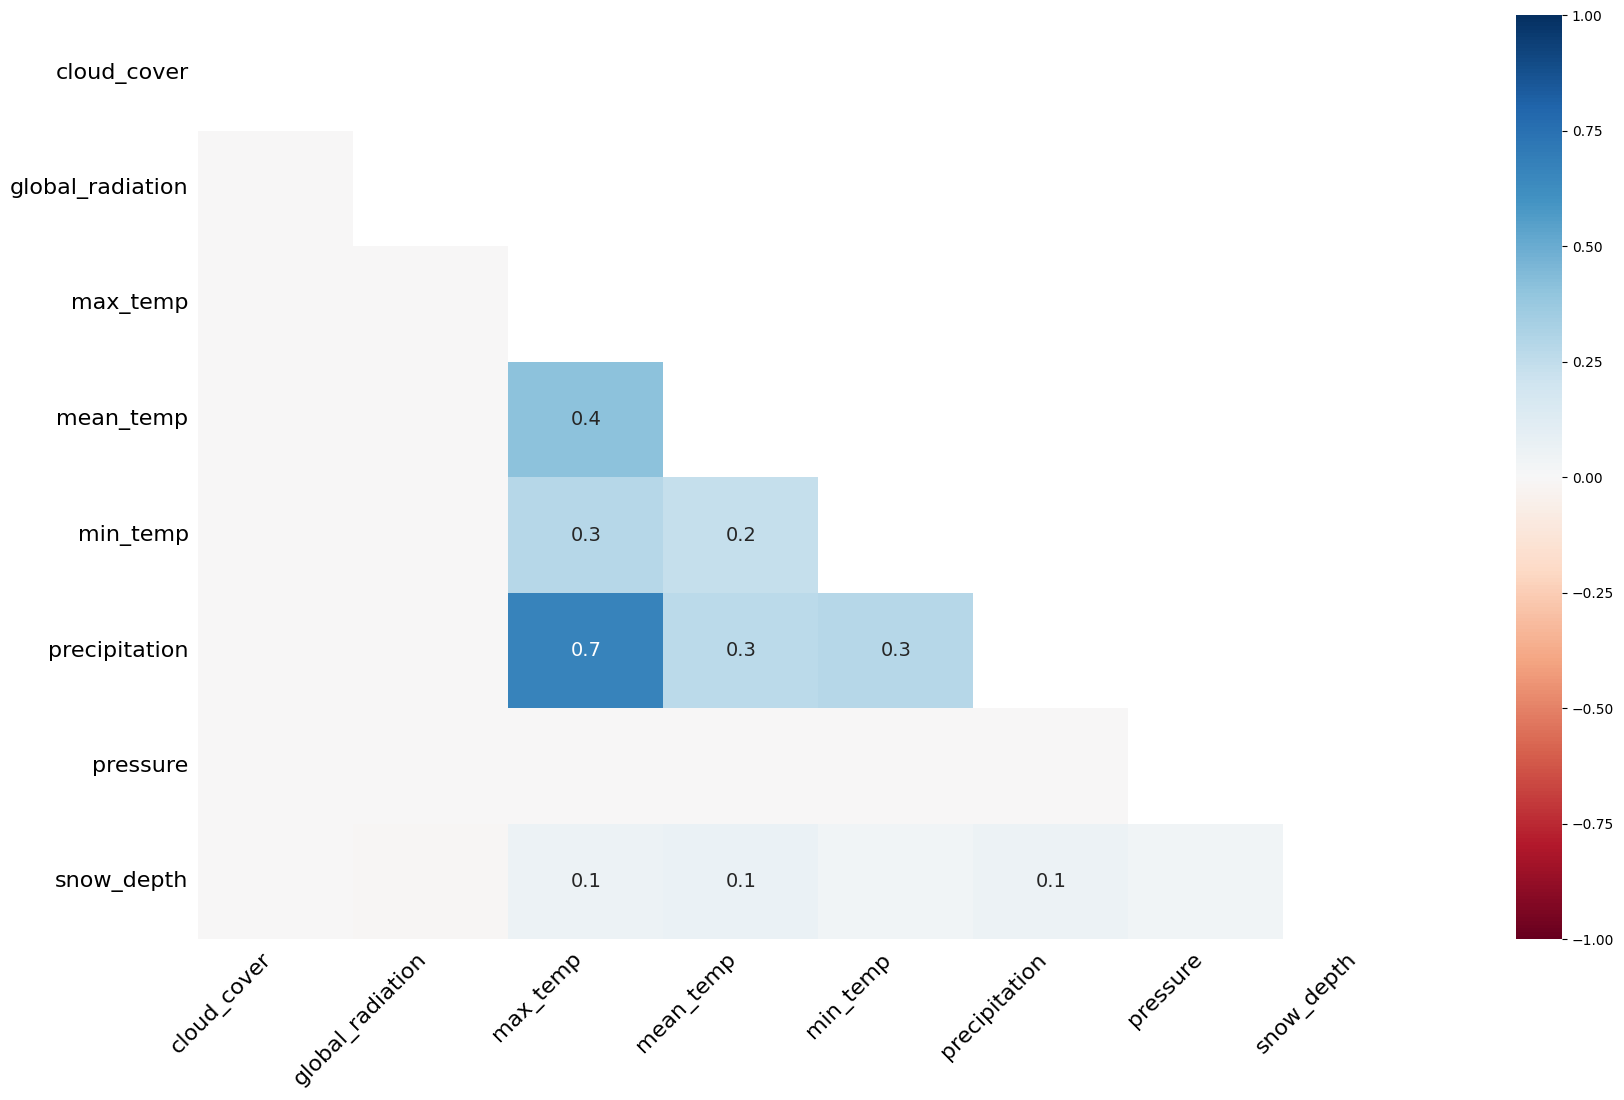

In [8]:
mno.heatmap(data)

<Axes: >

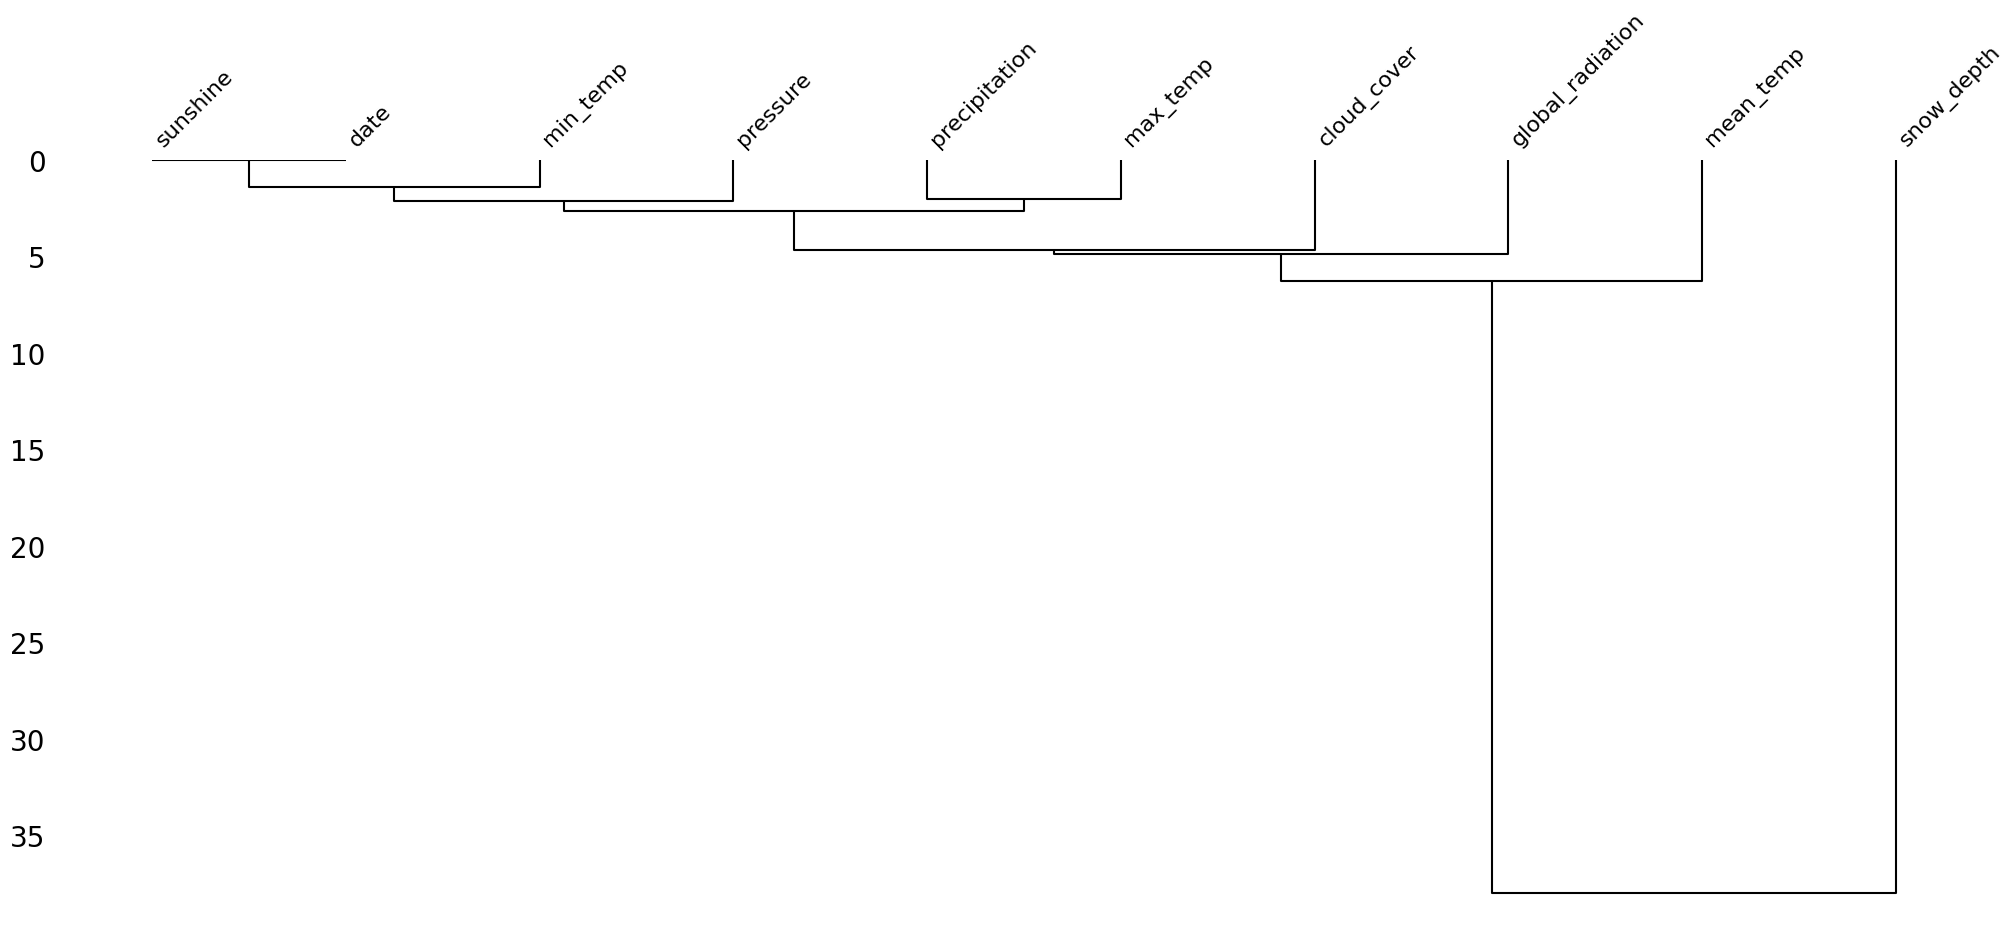

In [9]:
mno.dendrogram(data)

As you can see, we have a large number of missing values in the 'snow_depth' and 'Precipitation' features. Additionally, they has low variance, meaning it provides little information and a lot of outliers. Therefore, we will drop thase features.

In [10]:
data.drop(["snow_depth" , "precipitation"] , axis=1 , inplace=True)

As you know, the month in which our observation occurred impacts the weather.

In [11]:
data["Month"] = pd.to_datetime(data["date"] , format='%Y%m%d').dt.month
data.drop("date" , axis=1 , inplace=True)

In [12]:
data.head()

cloud_cover  sunshine  global_radiation  max_temp  mean_temp  min_temp  \
0          2.0       7.0              52.0       2.3       -4.1      -7.5   
1          6.0       1.7              27.0       1.6       -2.6      -7.5   
2          5.0       0.0              13.0       1.3       -2.8      -7.2   
3          8.0       0.0              13.0      -0.3       -2.6      -6.5   
4          6.0       2.0              29.0       5.6       -0.8      -1.4   

   pressure  Month  
0  101900.0      1  
1  102530.0      1  
2  102050.0      1  
3  100840.0      1  
4  102250.0      1

In [13]:
'''
use mode of "cloud_cover" to fill the missing values
use mean of "global_radiation" to fill the missing values
use mean of "mean_temp" to fill the missing values

'''
data.fillna({
    "cloud_cover" : data["cloud_cover"].mode(),
    "global_radiation" : data["global_radiation"].mean() ,
    "mean_temp": data["mean_temp"].mean()
} , inplace=True)

#Drop the remaining rows that have missing values
data.dropna(inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15311 entries, 0 to 15340
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       15311 non-null  float64
 1   sunshine          15311 non-null  float64
 2   global_radiation  15311 non-null  float64
 3   max_temp          15311 non-null  float64
 4   mean_temp         15311 non-null  float64
 5   min_temp          15311 non-null  float64
 6   pressure          15311 non-null  float64
 7   Month             15311 non-null  int32  
dtypes: float64(7), int32(1)
memory usage: 1016.7 KB


The 'Month' feature has 12 unique classes. Therefore, using binary encoding is the best option

In [15]:
encoder =BinaryEncoder(cols = 'Month' , return_df = True)
data = encoder.fit_transform(data)

c:\Users\SAM-Tech\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\SAM-Tech\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\SAM-Tech\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:1

In [16]:
data.sample(5)

cloud_cover  sunshine  global_radiation  max_temp  mean_temp  min_temp  \
6310           7.0       2.7             124.0       6.6       11.3       6.5   
5004           7.0       0.0              49.0      18.3       13.7      11.7   
11831          4.0      12.3             302.0      20.5       13.5       7.6   
15238          0.0      10.9             202.0      25.2       19.4      13.7   
1114           6.0       0.1              18.0       8.9        6.4       3.1   

       pressure  Month_0  Month_1  Month_2  Month_3  
6310   101720.0        0        1        0        0  
5004   101470.0        1        0        0        1  
11831  102570.0        0        1        0        1  
15238  101840.0        1        0        0        1  
1114   101940.0        0        0        0        1

<Axes: >

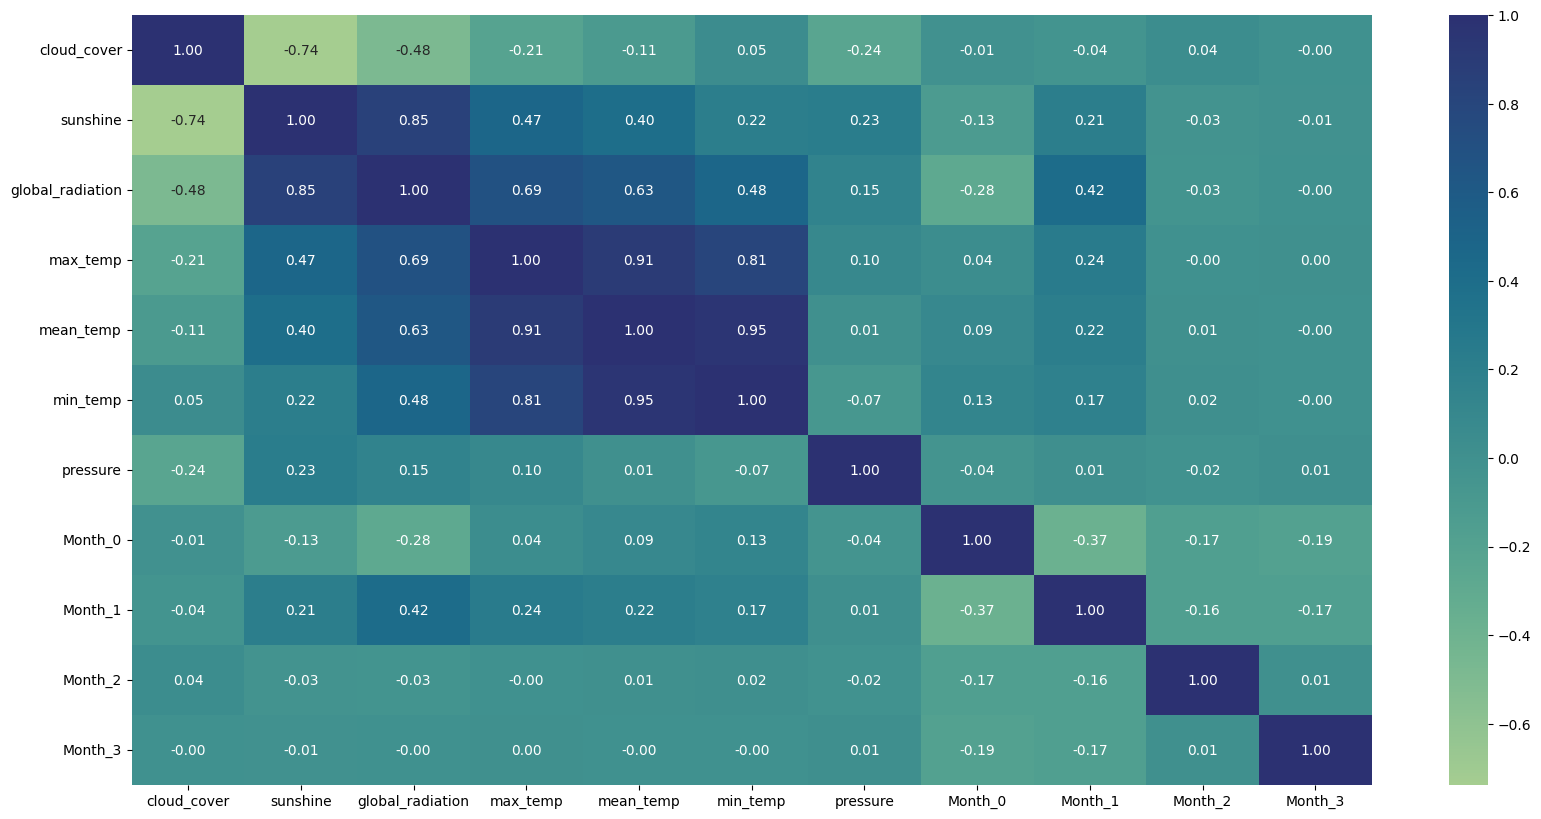

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr() , annot=True , fmt=".2f" , cmap="crest")

In [129]:
X = data.drop("max_temp" ,axis=1)
y = data["max_temp"]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [131]:
# Let's check the shape of the train and test dataset
print(f'The shape of the train and test set for the independent variables are : X_train = {X_train.shape}, X_test = {X_test.shape}')
print(f'The shape of the train and test set for the dependent variables are : y_train = {y_train.shape}, y_test = {y_test.shape}')

The shape of the train and test set for the independent variables are : X_train = (12248, 10), X_test = (3063, 10)
The shape of the train and test set for the dependent variables are : y_train = (12248,), y_test = (3063,)


Because we have a few outliers in the dataset, I prefer to use Robust Scaler, which will help address this issue.

In [132]:
robust_scale_features =  [
    "cloud_cover" , "sunshine" , "global_radiation",
    "mean_temp" , "min_temp" , "pressure"
]

In [133]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h3 align="left"> <font color='red'>  Model building </font></h3>

## Linear Regression

In [134]:
from sklearn.linear_model import LinearRegression

In [135]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [136]:
# sklearn regression module
y_pred1 = lin_reg.predict(X_test)

#Evaluvation: RMSE
rmse = np.sqrt(mean_squared_error(y_pred1, y_test))

# R_square
R_square = lin_reg.score(X_test,y_test)
print('The RMSE is: ',rmse)
print('R square obtain for scikit learn library is :',R_square)

The RMSE is:  2.301438438657086
R square obtain for scikit learn library is : 0.8744673929663239


In [137]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred1})
reg_model_diff

Actual value  Predicted value
10216           0.8         3.183447
2598            1.5         2.461006
1370           15.9        16.269851
7453           15.4        24.271944
15090          16.9        17.182084
...             ...              ...
12642          21.5        23.218152
8262           23.9        28.666013
5920           10.5        11.621114
1595           18.5        16.209502
73              1.3         3.635458

[3063 rows x 2 columns]

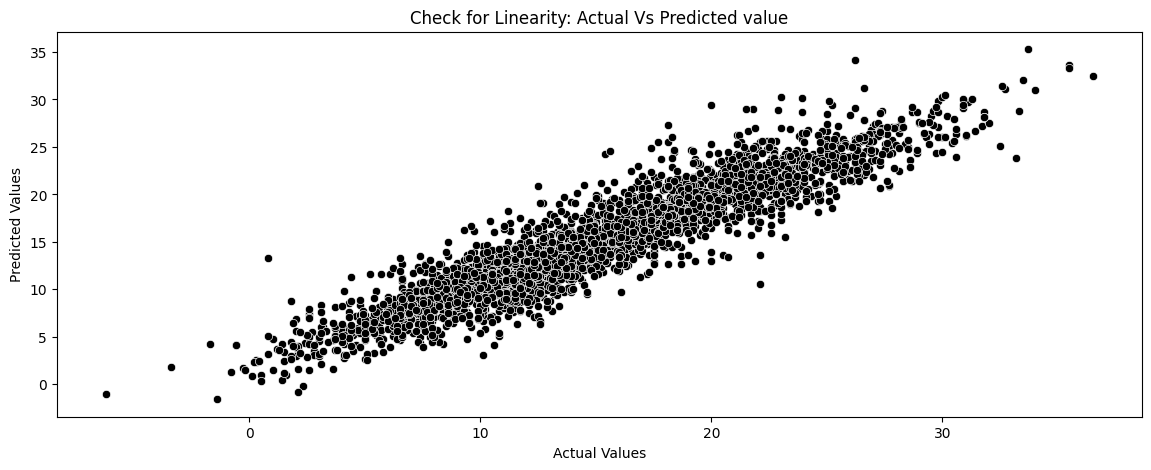

In [138]:
# Correct way to plot
plt.figure(figsize=(14, 5))
sns.scatterplot(x=y_test, y=y_pred1, color='black')
plt.title('Check for Linearity: Actual Vs Predicted value')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## Huber regression

In [139]:
from sklearn.linear_model import HuberRegressor

In [140]:

huber_reg = HuberRegressor()


# Define the grid of hyperparameters to search
param_grid = {
    'epsilon': [1.1, 1.35, 1.5],        # Controls the number of outliers the model is robust to
    'alpha': [0.0001, 0.001, 0.01],     # Regularization strength
    'max_iter': [100, 500, 1000]        # Number of iterations
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=huber_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HuberRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'epsilon': [1.1, 1.35, 1.5],
                         'max_iter': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [141]:
# sklearn regression module
y_pred2 = grid_search.best_estimator_.predict(X_test)

#Evaluvation: RMSE
rmse = np.sqrt(mean_squared_error(y_pred2, y_test))

# R_square
R_square = grid_search.best_estimator_.score(X_test,y_test)
print('The RMSE is: ',rmse)
print('R square obtain for scikit learn library is :',R_square)

The RMSE is:  2.3001834040582754
R square obtain for scikit learn library is : 0.874604268065828


In [142]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred2})
reg_model_diff

Actual value  Predicted value
10216           0.8         2.829601
2598            1.5         2.464633
1370           15.9        16.082947
7453           15.4        24.549093
15090          16.9        17.191021
...             ...              ...
12642          21.5        23.267602
8262           23.9        28.941413
5920           10.5        11.756345
1595           18.5        16.323318
73              1.3         3.396602

[3063 rows x 2 columns]

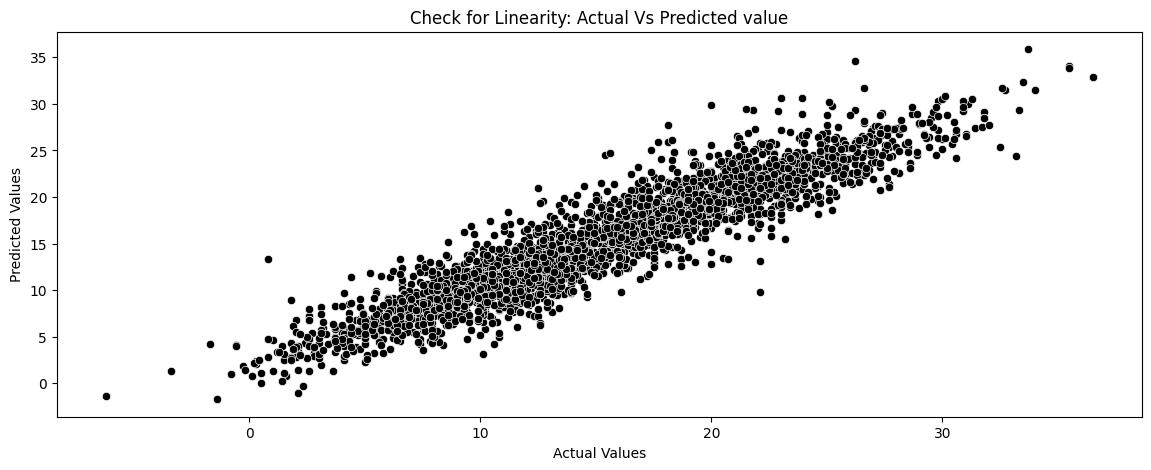

In [143]:
# Correct way to plot
plt.figure(figsize=(14, 5))
sns.scatterplot(x=y_test, y=y_pred2, color='black')
plt.title('Check for Linearity: Actual Vs Predicted value')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## RANSAC regression

In [144]:
from sklearn.linear_model import RANSACRegressor

In [145]:
# Create a RANSACRegressor model with a base estimator of LinearRegression
ransac = RANSACRegressor(base_estimator=LinearRegression())

# Define the grid of hyperparameters to search
param_grid = {
    'min_samples': [0.1, 0.5, 0.9],        # Minimum number of samples for fitting the model
    'residual_threshold': [5.0, 10.0, 15.0],  # Maximum residual for a data point to be classified as an inlier
    'max_trials': [100, 500, 1000],        # Maximum number of iterations for random sample selection
    'stop_n_inliers': [300, 500, 700]      # Number of inliers required to stop the algorithm early
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ransac, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model using Grid Search
grid_search.fit(X_train, y_train)

c:\Users\SAM-Tech\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


GridSearchCV(cv=5, estimator=RANSACRegressor(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'max_trials': [100, 500, 1000],
                         'min_samples': [0.1, 0.5, 0.9],
                         'residual_threshold': [5.0, 10.0, 15.0],
                         'stop_n_inliers': [300, 500, 700]},
             scoring='neg_mean_squared_error')

In [146]:
# sklearn regression module
y_pred3 = grid_search.best_estimator_.predict(X_test)

#Evaluvation: RMSE
rmse = np.sqrt(mean_squared_error(y_pred3, y_test))

# R_square
R_square =grid_search.best_estimator_.score(X_test,y_test)
print('The RMSE is: ',rmse)
print('R square obtain for scikit learn library is :',R_square)

The RMSE is:  2.300764141389453
R square obtain for scikit learn library is : 0.8745409416585357


In [147]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred3})
reg_model_diff

Actual value  Predicted value
10216           0.8         3.153512
2598            1.5         2.513979
1370           15.9        16.240495
7453           15.4        24.288706
15090          16.9        17.121269
...             ...              ...
12642          21.5        23.195442
8262           23.9        28.672115
5920           10.5        11.625513
1595           18.5        16.198967
73              1.3         3.588521

[3063 rows x 2 columns]

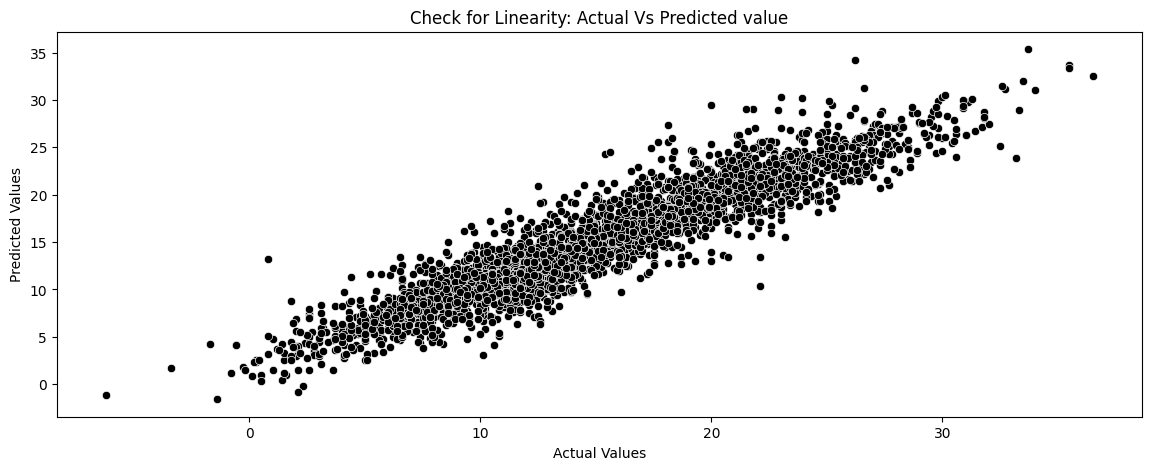

In [148]:
# Correct way to plot
plt.figure(figsize=(14, 5))
sns.scatterplot(x=y_test, y=y_pred3, color='black')
plt.title('Check for Linearity: Actual Vs Predicted value')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## ElasticNet

In [149]:
from sklearn.linear_model import ElasticNet

In [150]:
Elastic_reg = ElasticNet()


# Define the grid of hyperparameters to search
param_grid = {
    'alpha': [0.1, 1.0, 10.0],          # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.9],        # The ElasticNet mixing parameter (0 = Ridge, 1 = Lasso)
    'max_iter': [1000, 2000, 3000]      # Number of iterations
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator= Elastic_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model using Grid Search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9],
                         'max_iter': [1000, 2000, 3000]},
             scoring='neg_mean_squared_error')

In [151]:
# sklearn regression module
y_pred4 = grid_search.best_estimator_.predict(X_test)

#Evaluvation: MSE
rmse = np.sqrt(mean_squared_error(y_pred4, y_test))

# R_square
R_square =grid_search.best_estimator_.score(X_test,y_test)
print('The RMSE is: ',rmse)
print('R square obtain for scikit learn library is :',R_square)

The RMSE is:  2.507551167526321
R square obtain for scikit learn library is : 0.8509755832116215


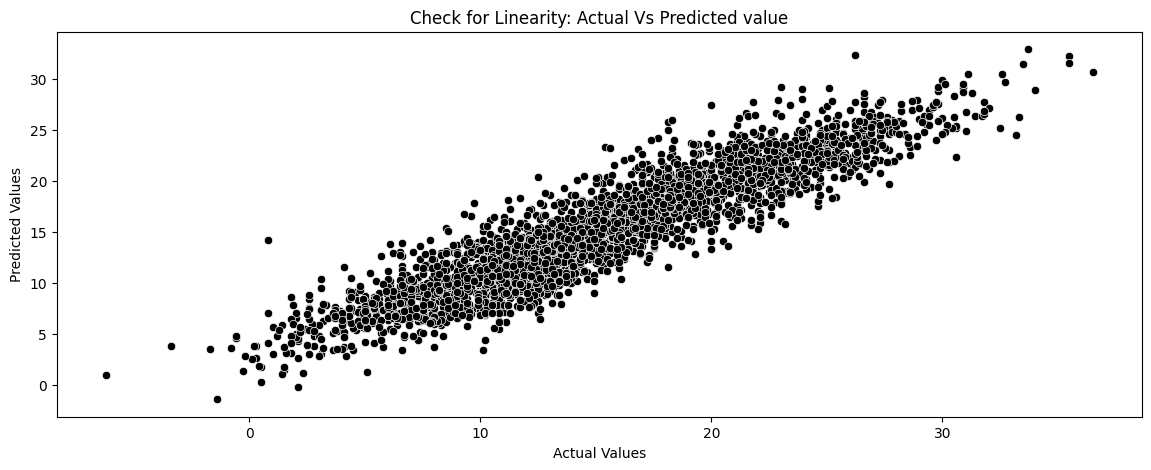

In [152]:
# Correct way to plot
plt.figure(figsize=(14, 5))
sns.scatterplot(x=y_test, y=y_pred4, color='black')
plt.title('Check for Linearity: Actual Vs Predicted value')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()